# Process True False Dataset

Dataset from the paper [The Internal State of an LLM Knows When It's Lying](https://aclanthology.org/2023.findings-emnlp.68.pdf)

You can download the dataset [here](http://azariaa.com/Content/Datasets/true-false-dataset.zip).

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "CPU"
print(f'Device: {device}')

Device: cuda


In [2]:
dataset_name = 'true-false-dataset'
categories = ['animals', 'cities', 'companies', 'elements', 
              'facts', 'generated', 'inventions']

data_path = f'../Data/{dataset_name}'
embeddings_path = f'Embeddings/{dataset_name}'
concepts_path = f'Concepts/{dataset_name}'
cos_sims_path = f'Cosine_Similarities/{dataset_name}'
images_path = f'Images/{dataset_name}'

In [3]:
embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
if os.path.exists(embeddings_file):
    print('Embeddings file found. No need to load model and tokenizer.')
    model = None
    tokenizer = None
else:
    print('Embeddings file NOT found. Loading model and tokenizer...')
    
    from huggingface_hub import notebook_login
    notebook_login()
    
    model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.to(device)
    model.eval()
    print('Done.')

Embeddings file found. No need to load model and tokenizer.


## Processing statements

In [4]:
def get_category(category, data_path):
    cat_path = os.path.join(data_path, f'{category}_true_false.csv')
    df_cat = pd.read_csv(cat_path)
    df_cat['category'] = category
    return df_cat

In [5]:
def get_categories(categories, data_path):
    df_list = []
    for category in categories:
        df_cat = get_category(category, data_path=data_path)
        df_list.append(df_cat)
    df = pd.concat(df_list, ignore_index=True)
    return df

In [6]:
def get_hidden_states(statements, model, tokenizer, embeddings_path, 
                      device=device, save=True):
    embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
    if os.path.exists(embeddings_file):
        print('   Hidden states file found.')
        hidden_states = torch.load(embeddings_file)
    else:
        print('   Hidden states file NOT found.')
        hidden_states = []
        for statement in tqdm(statements, desc='Getting hidden states'):
            tokenized_prompt = tokenizer(statement, return_tensors="pt").to(device)
            output = model(**tokenized_prompt, output_hidden_states=True)
            
            features = output.hidden_states[-1][0][-1]
            hidden_state = features.cpu().detach()
            hidden_states.append(hidden_state)
            
            del output
            del features
            torch.cuda.empty_cache()

        hidden_states = torch.stack(hidden_states, dim=0)
        # Center embeddings
        average_embedding = torch.mean(hidden_states, 0) 
        centered_hidden_states = hidden_states - average_embedding
        if save:
            os.makedirs(embeddings_path, exist_ok=True)
            torch.save(hidden_states, embeddings_file)
            
    return hidden_states

In [7]:
def process_data(categories, model, tokenizer, data_path, embeddings_path):
    print('Getting statements...', end=' ')
    df = get_categories(categories, data_path=data_path)
    df.to_csv(os.path.join(data_path, 'metadata.csv'))
    statements = df['statement'].to_list()
    print('Done.')

    print('Getting hidden states...')
    hidden_states = get_hidden_states(statements, model, tokenizer, embeddings_path)
    print('Done.')

    return df, hidden_states

In [8]:
df, hidden_states = process_data(categories, model, tokenizer, data_path, embeddings_path)

Getting statements... Done.
Getting hidden states...
   Hidden states file found.
Done.


In [9]:
print(f'Number of statements: {df.shape[0]}')
print(f'Number of true statements: {df[df["label"] == 1].shape[0]}')
print(f'Number of false statements: {df[df["label"] == 0].shape[0]}')
print(f'Number of statement categories: {len(df["category"].unique())}')

Number of statements: 6330
Number of true statements: 3187
Number of false statements: 3143
Number of statement categories: 7


## Computing concepts

In [10]:
def compute_single_concept(concept, concept_type, df, hidden_states):
    # Get embeddings from the concept
    hidden_states_cat = hidden_states[df[concept_type] == concept] 
    # Get average embedding
    concept_vect = torch.mean(hidden_states_cat, 0) 
    # Normalize vector
    concept_vect = concept_vect / concept_vect.norm() 
    return concept_vect

def compute_concepts(df, hidden_states, concepts_path, save=True):
    label_map = {0: 'False', 1: 'True'}
    categories = list(df['category'].unique())
    labels = list(df['label'].unique())
    concepts = {}

    print('Computing categories concept vectors...', end=' ')
    for category in categories:
        concept_vect = compute_single_concept(category, 'category', df, hidden_states)
        concepts[category] = concept_vect
    print('Done.')

    print('Computing labels concept vectors...', end=' ')
    for label in labels:
        concept_vect = compute_single_concept(label, 'label', df, hidden_states)
        concepts[label_map[label]] = concept_vect
    print('Done.')
        
    if save:
        print('Saving concepts...', end=' ')
        os.makedirs(concepts_path, exist_ok=True)
        concepts_path = os.path.join(concepts_path, 'concepts.pt')
        torch.save(concepts, concepts_path)
        print('Done.')

    print(f'Concepts computed: {list(concepts.keys())}')
    return concepts

In [11]:
concepts = compute_concepts(df, hidden_states, concepts_path)

Computing categories concept vectors... Done.
Computing labels concept vectors... Done.
Saving concepts... Done.
Concepts computed: ['animals', 'cities', 'companies', 'elements', 'facts', 'generated', 'inventions', 'True', 'False']


## Compute cosine similarities

In [12]:
def compute_cosine_sims(hidden_states, concept_embs, concept_names, cos_sims_path,
                        save=True):
    print('Computing cosine similarities...', end=' ')
    similarities = cosine_similarity(hidden_states, concept_embs)
    sim_df = pd.DataFrame(similarities, columns=concept_names)
    print('Done.')
    if save:
        print('Saving cosine similarities...', end=' ')
        os.makedirs(cos_sims_path, exist_ok=True)
        cos_sims_df_path = os.path.join(cos_sims_path, 'cosine_similarities.csv')
        sim_df.to_csv(cos_sims_df_path)
        print('Done.')
        
    return sim_df

In [13]:
concept_embs = torch.stack(list(concepts.values()), dim=0)
concept_names = list(concepts.keys())
sim_df = compute_cosine_sims(hidden_states, concept_embs, concept_names, cos_sims_path)

Computing cosine similarities... Done.
Saving cosine similarities... Done.


In [14]:
def plot_cos_sim_histograms(df, sim_df, images_path):
    categories = list(df['category'].unique())
    fig, axs = plt.subplots(3, 3, figsize=(6,6), sharex=True)
    bins = np.linspace(0, 1, 20)
    for i, category in enumerate(categories):
        ix, iy = int(i/3), i%3
        sns.kdeplot(sim_df[df['category']==category][category], 
                    label='In concept', ax=axs[ix,iy])
        sns.kdeplot(sim_df[df['category']!=category][category], 
                    label='Out of concept', ax=axs[ix,iy])
        axs[ix,iy].set_xlabel('')
        axs[ix,iy].set_ylabel('')
        axs[ix,iy].set_title(category)
    
    label_map = {0: 'False', 1: 'True'}
    for label in [0,1]:
        i += 1
        ix, iy = int(i/3), i%3
        sns.kdeplot(sim_df[df['label']==label][category], 
                    label='In concept', ax=axs[ix,iy])
        sns.kdeplot(sim_df[df['label']!=label][category], 
                    label='Out of concept', ax=axs[ix,iy])
        axs[ix,iy].set_xlabel('')
        axs[ix,iy].set_ylabel('')
        axs[ix,iy].set_title(label_map[label])
    
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.26, 0.9))
    xl = fig.supxlabel('Cosine Similarity')
    yl = fig.supylabel('Proportion of samples')
    title = fig.suptitle('Cosine similarity in/out of concept')
    fig.tight_layout()

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    cos_sims_image_path = os.path.join(images_path, 'cosine_similarities.png')
    fig.savefig(cos_sims_image_path, bbox_extra_artists=(lgd,xl,yl,title), 
                bbox_inches='tight')
    print('Done.')
    
    plt.show()

Saving image... Done.


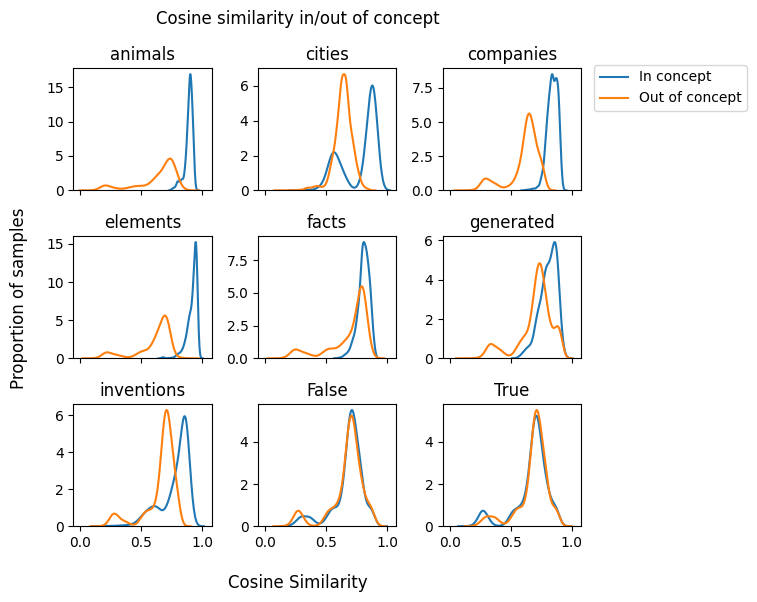

In [15]:
plot_cos_sim_histograms(df, sim_df, images_path)

In [16]:
def show_similarity_concepts(concepts, images_path):
    concept_embs = torch.stack(list(concepts.values()), dim=0)
    concept_names = list(concepts.keys())
    cos_sim_concepts_df = compute_cosine_sims(concept_embs, 
                                              concept_embs, 
                                              concept_names, 
                                              '', save=False)
    cos_sim_concepts_df['Concept'] = concepts
    cos_sim_concepts_df = cos_sim_concepts_df.set_index('Concept')
    ax = sns.heatmap(cos_sim_concepts_df, annot=True, fmt=".2f", cmap="Blues",
               cbar_kws={'label': 'Cosine similarity'})
    ax.set_title('Cosine similarity between concepts')

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    cos_sims_image_path = os.path.join(images_path, 'cosine_similarities_concepts.png')
    plt.savefig(cos_sims_image_path)
    print('Done.')
    
    plt.show()

Computing cosine similarities... Done.
Saving image... Done.


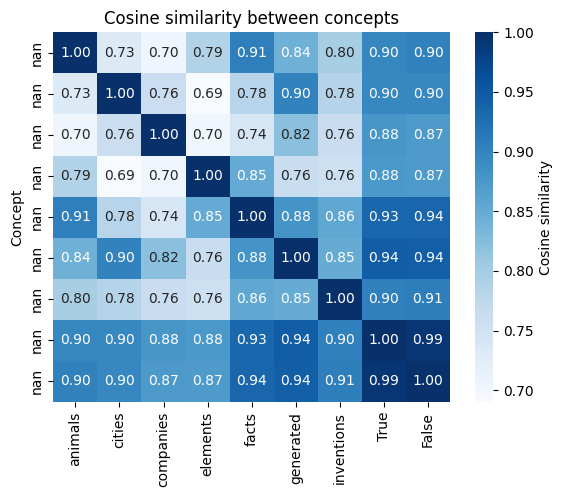

In [17]:
show_similarity_concepts(concepts, images_path)

## Threshold-based models

In [18]:
class ThresholdModel:
    def __init__(self):
        pass

    def predict(self, X_eval, thresh=None):
        if thresh is None:
            thresh = self.thresh
        return (X_eval[:,0] > thresh).astype(int)

    def loss(self, thresh):
        y_pred = self.predict(self.X, thresh)
        error = 1 - accuracy_score(self.y, y_pred)
        return error
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        result = minimize_scalar(self.loss, bounds=(-1, 1), method='bounded')
        self.thresh, self.loss = result.x, result.fun
        return self.thresh, self.loss

def train_test_threshold(X, y, stratify_list=None):
    model = ThresholdModel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=42,
                                                        stratify=stratify_list)
    thresh, train_error = model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test, thresh)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    return thresh, train_error, test_error

def get_concept_X_y_list(df, sim_df, concept, concept_type):
    label_map = {0: 'False', 1: 'True'}
    if concept in label_map.keys():
        concept_name = label_map[concept]
    else:
        concept_name = concept
    X = sim_df[[concept_name]].to_numpy()
    y = (df[concept_type]==concept).to_numpy().astype(int)
    concept_list = df['label'].astype(str).values
    return X, y, concept_list

In [19]:
def get_global_threshold(df, sim_df, concept_types = ['category', 'label'],
                        verbose=True):
    X_list = []
    y_list = []
    concept_lists = []
    for concept_type in concept_types:
        concepts = list(df[concept_type].unique())
        for concept in concepts:
            X, y, concept_list = get_concept_X_y_list(df, sim_df, concept, concept_type)
            X_list.append(X)
            y_list.append(y)
            concept_lists.append(concept_list)
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list)
    concept_list = np.concatenate(concept_lists)

    thresh, train_error, test_error = train_test_threshold(X, y, stratify_list=concept_list)
    if verbose:
        print(f'Global threshold: {thresh:.3f}')
        print(f'Train error: {train_error:.3f} | Test error: {test_error:.3f}')
    return thresh, train_error, test_error

In [20]:
global_thresh, global_train_error, global_test_error = get_global_threshold(df, sim_df)

Global threshold: 0.834
Train error: 0.168 | Test error: 0.172


In [21]:
def get_concept_threshold(df, sim_df, concept, concept_type):
    X, y, concept_list = get_concept_X_y_list(df, sim_df, concept, concept_type)
    thresh, train_error, test_error = train_test_threshold(X, y, stratify_list=concept_list)
    return thresh, train_error, test_error

def get_individual_thresholds(df, sim_df, concept_types = ['category', 'label'],
                                verbose=True):
    label_map = {0: 'False', 1: 'True'}
    thresholds = {}
    train_errors = {}
    test_errors = {}
    for concept_type in concept_types:
        concepts = list(df[concept_type].unique())
        for concept in concepts:
            thresh, train_error, test_error = get_concept_threshold(df, sim_df, concept, concept_type)
            if concept in label_map.keys():
                concept_name = label_map[concept]
            else:
                concept_name = concept
            thresholds[concept_name] = thresh
            train_errors[concept_name] = train_error
            test_errors[concept_name] = test_error
            if verbose:
                print(f'Concept: {concept_name.ljust(10)} | Threshold: {thresh:.3f} | Train error: {train_error:.3f} | Test error: {test_error:.3f}')
    return thresholds, train_errors, test_errors

In [22]:
thresholds, train_errors, test_errors = get_individual_thresholds(df, sim_df)

Concept: animals    | Threshold: 0.841 | Train error: 0.018 | Test error: 0.015
Concept: cities     | Threshold: 0.805 | Train error: 0.089 | Test error: 0.077
Concept: companies  | Threshold: 0.777 | Train error: 0.018 | Test error: 0.018
Concept: elements   | Threshold: 0.813 | Train error: 0.007 | Test error: 0.005
Concept: facts      | Threshold: 0.869 | Train error: 0.091 | Test error: 0.097
Concept: generated  | Threshold: 0.927 | Train error: 0.038 | Test error: 0.039
Concept: inventions | Threshold: 0.818 | Train error: 0.067 | Test error: 0.067
Concept: True       | Threshold: -0.528 | Train error: 0.497 | Test error: 0.496
Concept: False      | Threshold: 0.820 | Train error: 0.479 | Test error: 0.483


In [23]:
def plot_concept_thresh_errors(test_errors):
    fig, ax = plt.subplots(1,1)
    sns.barplot(test_errors, orient="y", ax=ax)
    ax.set_xlabel('Classification error')
    ax.set_ylabel('Concept')
    ax.set_title('Classification error of concept-specific threshold')
    plt.show()

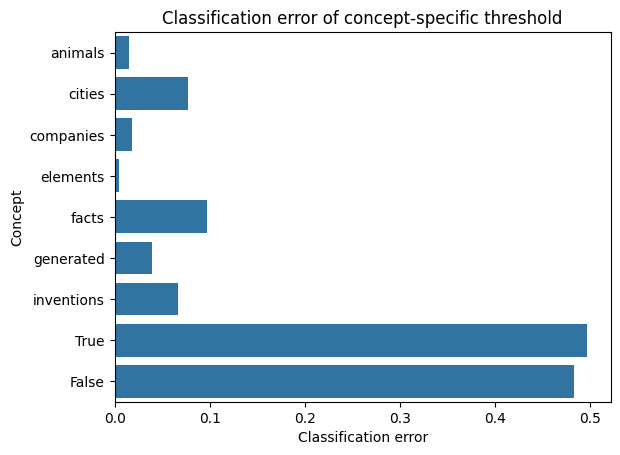

In [24]:
plot_concept_thresh_errors(test_errors)